In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import streamlit as st
import joblib

# Veriyi yükleme ve işleme (Önceki adımlar)
df = pd.read_csv('clustered_data_v2.csv')
important_features = ['grade_living_normalized', 'distance_to_point_km', 'nearest_station_distance_km', 'commute_time', 'lat','cluster_all_data','price']
df_wo_main = df[important_features]
df_wo_main = df_wo_main.drop(index=7252)



# IQR Yöntemi ile Aykırı Değerleri Bulma ve Baskılamak
def cap_outliers(df):
    capped_df = df.copy()
    for col in df.select_dtypes(include=[np.number]).columns:
        if col != 'price':
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            capped_df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
            capped_df[col] = np.where(df[col] > upper_bound, upper_bound, capped_df[col])
        else:
            capped_df[col] = df[col]
    return capped_df

df_wo_main_capped = cap_outliers(df_wo_main)


def train_catboost_model_with_gridsearch(df):
    y = df[df['cluster_all_data'] == 2]['price']
    X = df[df['cluster_all_data'] == 2].drop(columns=['cluster_all_data', 'price'], axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # StandardScaler ile normalizasyon
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define the parameter grid
    param_grid = {
    'depth': [2, 3, 4],
    'learning_rate': [0.03, 0.05, 0.07],
    'iterations': [500, 600, 700],
    'l2_leaf_reg': [5, 6, 7]
}

    # Create the CatBoostRegressor model
    model = CatBoostRegressor(verbose=0, random_state=42)

    # Perform GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_scaled, y_train)

    # Get the best model
    best_model = grid_search.best_estimator_
    
    # Print the best parameters
    print("Best Parameters:", grid_search.best_params_)

    # Predictions
    y_pred = best_model.predict(X_test_scaled)

    result_df = pd.DataFrame({
        'y_test': y_test,
        'y_pred': y_pred
    })
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'Root Mean Squared Error: {rmse}')

    r2 = r2_score(y_test, y_pred)
    print(f'R2 Score: {r2}')
    
    # Save the best model and scaler
    joblib.dump(best_model, 'model_cluster_2.pkl')
    joblib.dump(scaler, 'scaler_cluster_2.pkl')

    return result_df



result_df = train_catboost_model_with_gridsearch(df_wo_main_capped)

Best Parameters: {'depth': 3, 'iterations': 700, 'l2_leaf_reg': 6, 'learning_rate': 0.05}
Root Mean Squared Error: 256833.39051270243
R2 Score: 0.8168234794388856


In [21]:
result_df['y_test'] = result_df['y_test'].astype(int)
result_df['y_pred'] = result_df['y_pred'].astype(int)
result_df

,y_test,y_pred
9271,926500,924906
3748,2450000,2040350
16887,560000,568308
3103,1130000,1426961
2133,655000,530713
...,...,...
21308,580000,640225
15230,1085000,987408
11142,605000,698104
19459,387000,429153


In [41]:
result_df['absolute_error'] = np.abs(result_df['y_pred'] - result_df['y_test'])

# Sort the DataFrame based on absolute error
sorted_result_df = result_df.sort_values(by='absolute_error', ascending=False)
sorted_result_df = sorted_result_df.astype(int)

sorted_result_df

,y_test,y_pred,absolute_error
6402,2903000,1231092,1671907
17899,2458000,3699553,1241553
14774,1612500,2731779,1119279
300,3075000,2024518,1050481
656,3070000,2052154,1017845
...,...,...,...
16294,1307000,1308794,1794
8673,1090000,1091248,1248
7578,1700000,1698784,1215
4769,480000,480671,671


In [35]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_lot_normalized', 'floors',
       'waterfront', 'view', 'condition', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'nearest_station_distance_km',
       'bathroom_category', 'density', 'commute_time', 'distance_to_point_km',
       'is_near_shore', 'grade_living_normalized', 'bedrooms_cat',
       'lot_size_category', 'grade_living_category', 'outliers_ecod',
       'cluster_all_data', 'cluster_no_outlier', 'sqft_lot', 'grade_living'],
      dtype='object')

In [29]:
np.sqrt(mean_squared_error(result_df['y_test'], result_df['y_pred']))


415785.6601235221

In [42]:
sorted_result_df = sorted_result_df.merge(df[['outliers_ecod']], left_index=True, right_index=True)


In [43]:
sorted_result_df[sorted_result_df['outliers_ecod'] == 1]

,y_test,y_pred,absolute_error,outliers_ecod
6402,2903000,1231092,1671907,1
14774,1612500,2731779,1119279,1
300,3075000,2024518,1050481,1
656,3070000,2052154,1017845,1
6233,2200000,3197197,997197,1
...,...,...,...,...
3892,695500,703464,7964,1
14682,1295000,1289540,5459,1
3791,775000,770681,4318,1
12067,1195000,1198742,3742,1


In [44]:

# Initialize a dictionary to store the count of affected rows per column
affected_rows_count = {}

# Filter the DataFrame where cluster_all_data equals 2
filtered_df = df_wo_main[df_wo_main['cluster_all_data'] == 2]

compare_df = df_wo_main_capped[df_wo_main_capped['cluster_all_data'] == 2]

# Reset the index to ensure the index matches between the two DataFrames
filtered_df = filtered_df.reset_index(drop=True)
compare_df = compare_df.reset_index(drop=True)

# Iterate through each column
for col in filtered_df.columns:
    # Count the affected rows for the current column
    count = np.sum(filtered_df[col] != compare_df[col])
    
    # Store the count in the dictionary
    affected_rows_count[col] = count

# Print the counts
for col, count in affected_rows_count.items():
    print(f"Column '{col}': {count} affected rows.")

print(filtered_df.shape)
print(compare_df.shape)


Column 'grade_living_normalized': 44 affected rows.
Column 'distance_to_point_km': 0 affected rows.
Column 'nearest_station_distance_km': 1 affected rows.
Column 'commute_time': 0 affected rows.
Column 'lat': 0 affected rows.
Column 'cluster_all_data': 0 affected rows.
Column 'price': 0 affected rows.
(2103, 7)
(2103, 7)


In [46]:
sorted_result_df = sorted_result_df.astype(int)


<Axes: >

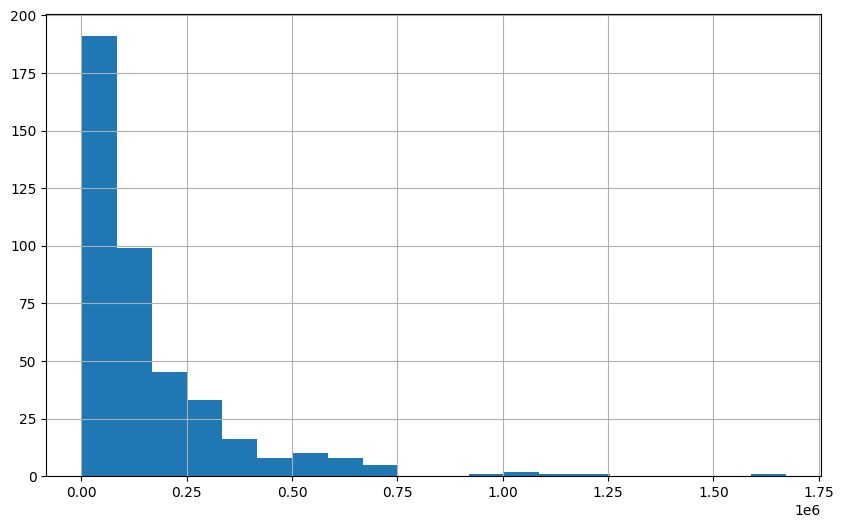

In [50]:
sorted_result_df['absolute_error'].hist(bins=20, figsize=(10, 6))

In [52]:
sorted_result_df.head(40)

,y_test,y_pred,absolute_error,outliers_ecod
6402,2903000,1231092,1671907,1
17899,2458000,3699553,1241553,0
14774,1612500,2731779,1119279,1
300,3075000,2024518,1050481,1
656,3070000,2052154,1017845,1
6233,2200000,3197197,997197,1
21576,3567000,2818294,748705,1
17767,2050000,1315754,734245,1
12517,970000,1684992,714992,1
12202,775000,1473517,698517,1
